# Data Exploration and Pre-Processing

This dataset contains chest x-ray images some of which are labeled as 'NORMAL' and otheras as 'PNEUMONIA' which are examples of patients that indeed have a case the potentially lethal respiratory infection. There are 5656 total images in a range of dimensions and all are greyscale. The dataset is sourced directly from [this Kaggle page](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) using the Kaggle API command (kaggle datasets download -d paultimothymooney/chest-xray-pneumonia). This kaggle page cites [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/2) as its original data source.  

## Data loading and sifting

In [1]:
# dependences for data loading and sifting
import numpy as np 
import pandas as pd 

import os
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
# file paths to data directories
train_dir = "data/train/"
test_dir = "data/test/"
val_dir = "data/val/"

# dictionary of volume of data per class per sample
class_balance_dict = {
    "Train Sample":[len(os.listdir(train_dir+"NORMAL")),len(os.listdir(train_dir+"PNEUMONIA"))],
    "Test Sample":[len(os.listdir(test_dir+"NORMAL")),len(os.listdir(test_dir+"PNEUMONIA"))],
    "Val Sample":[len(os.listdir(val_dir+"NORMAL")),len(os.listdir(val_dir+"PNEUMONIA"))]
}

# class balance dictionary as a dataframe with row index representing class and column index representing sample
import pandas as pd
class_balance_df = pd.DataFrame(class_balance_dict,index=['Normal', 'Pneumonia'])
class_balance_df

,Train Sample,Test Sample,Val Sample
Normal,1341,234,8
Pneumonia,3875,390,8


Text(0, 0.5, 'Percent Class Representation')

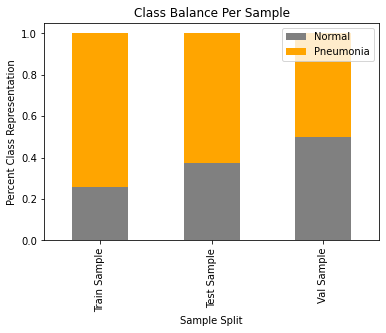

In [3]:
import matplotlib.pyplot as plt

# normalize data as percentage and rotate for plotting
class_balance_normalized = class_balance_df.T.apply(lambda x: x/x.sum(), axis=1)
 
# create stacked bar chart for students DataFrame
class_balance_normalized.plot(kind='bar', stacked=True, color=['gray', 'orange',])

# Add Title and Labels
plt.title('Class Balance Per Sample')
plt.xlabel('Sample Split')
plt.ylabel('Percent Class Representation')

The data comes already labeled and split for 3 way validation. The Train sample is, naturally, the largest of the 3 with over five thousand images, 66% of which are cases of pneumonia which will be the target prediction. The next largest is the test sample with over six hundred images of which 40% are trues cases of pneumonia. Finally, the validation set contains 16 images with each class being represented equally at 50%.  

## Sanity Check: Can the images be displayed easily?

In [4]:
# an example of (first) and Normal x-ray scan and (second) and x-ray scan showing pneumonia
Image.open("data/train/NORMAL/IM-0115-0001.jpeg").show()
Image.open("data/train/PNEUMONIA/person1001_bacteria_2932.jpeg").show()

## Generate Data from Sub-Directory Structure

In [5]:
# dependencies for modeling
from keras import layers
from keras import models
from keras import optimizers

In [6]:
# instatiating a data degenerater for each split sample 
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)
                                   
val_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_directory(
                       train_dir,
                       target_size=(150,150),
                       batch_size=16,
                       class_mode='binary',
                       color_mode='grayscale')

test_data_generator = test_datagen.flow_from_directory(
                      test_dir,
                      target_size=(150,150),
                      batch_size=16,
                      class_mode='binary',
                      color_mode='grayscale')

val_data_generator = val_datagen.flow_from_directory(
                     val_dir,
                     target_size=(150,150),
                     batch_size=16,
                     class_mode='binary',
                     color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Generate Structured Data from Generators for use with SciKit Learn Tools

In [7]:
def dataframe_from_generator(generator,batch_size:16,verbose:True):
    """
    Takes in an ImageDataGenerator object (keras)
    Converts and reshapes data into 2D arrays, then into DataFrames
    Concatenates DataFrames together into a single DataFrame 
    Returns gen_df, a Dataframe containing the entire image dataset in a structured, numerical format. 
    """
    # asign dataset to a concise variable, count of batches in dataset
    data = generator
    batch_count = len(data)

    #instantiate empty dataframe to concatenate later
    gen_df = pd.DataFrame()

    # iterate through however many batches occur in the dataset
    for i in range(batch_count):
        # asign X and y variables to features and labels
        X_batch,y_batch = data[i]

        # make y array vertical
        vertical_y = zip(*[y_batch])
        vertical_y = np.array([list(tuple) for tuple in vertical_y])
        
        # if verbose:
        #     print(f"y batch {i}/{batch_count} now has shape: ",vertical_y.shape)

        # flatten X, so each row in a 2D array represents a single image
        flat_X = X_batch.reshape(batch_size,-1)
        
        # if verbose:
        #     print(f"X batch {i}/{batch_count} now has shape: ",flat_X.shape)

        # convert arrays to dataframes
        y_batch_df = pd.DataFrame(vertical_y, columns=['label'])
        X_batch_df = pd.DataFrame(flat_X)

        # concatenate batch dataframes horizontally 
        batch_df = pd.concat([y_batch_df, X_batch_df], axis=1)

        # concatenate batch dataframe to generator dataframe vertically
        gen_df = pd.concat([gen_df,batch_df],axis=0)

        if verbose:
            print("----------------------------------")
            print(f"\nbatch {i}/{batch_count} complete")

    return gen_df

In [8]:
train_df = dataframe_from_generator(train_data_generator,16,verbose=True)
train_df.info()

----------------------------------

batch 0/326 complete
----------------------------------

batch 1/326 complete
----------------------------------

batch 2/326 complete
----------------------------------

batch 3/326 complete
----------------------------------

batch 4/326 complete
----------------------------------

batch 5/326 complete
----------------------------------

batch 6/326 complete
----------------------------------

batch 7/326 complete
----------------------------------

batch 8/326 complete
----------------------------------

batch 9/326 complete
----------------------------------

batch 10/326 complete
----------------------------------

batch 11/326 complete
----------------------------------

batch 12/326 complete
----------------------------------

batch 13/326 complete
----------------------------------

batch 14/326 complete
----------------------------------

batch 15/326 complete
----------------------------------

batch 16/326 complete
------------------------

In [9]:
test_df = dataframe_from_generator(test_data_generator,16,verbose=True)
test_df.info()

----------------------------------

batch 0/39 complete
----------------------------------

batch 1/39 complete
----------------------------------

batch 2/39 complete
----------------------------------

batch 3/39 complete
----------------------------------

batch 4/39 complete
----------------------------------

batch 5/39 complete
----------------------------------

batch 6/39 complete
----------------------------------

batch 7/39 complete
----------------------------------

batch 8/39 complete
----------------------------------

batch 9/39 complete
----------------------------------

batch 10/39 complete
----------------------------------

batch 11/39 complete
----------------------------------

batch 12/39 complete
----------------------------------

batch 13/39 complete
----------------------------------

batch 14/39 complete
----------------------------------

batch 15/39 complete
----------------------------------

batch 16/39 complete
----------------------------------

batch

In [10]:
val_df = dataframe_from_generator(val_data_generator,16,verbose=True)
val_df.info()

----------------------------------

batch 0/1 complete
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Columns: 22501 entries, label to 22499
dtypes: float32(22501)
memory usage: 1.4 MB


## Sanity Check: is the data ready to fit a model?

In [11]:
# build a simple convultional neural network
base_model = models.Sequential()
base_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
base_model.add(layers.MaxPooling2D((2, 2)))
base_model.add(layers.Flatten())
base_model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
# compile model from above
base_model.compile(loss='binary_crossentropy',metrics=['acc'])

In [20]:
# fit the model to the training data and validate with the test sample
base_model.fit(train_data_generator, 
               batch_size=16,
               epochs=10,
               steps_per_epoch=25,
               validation_data=test_data_generator,
               validation_steps=15
               )

Epoch 1/10
25/25 [==============================] - 9s 365ms/step - loss: 0.1411 - acc: 0.9450 - val_loss: 0.4256 - val_acc: 0.8250
Epoch 2/10
25/25 [==============================] - 8s 334ms/step - loss: 0.1254 - acc: 0.9425 - val_loss: 0.5044 - val_acc: 0.7958
Epoch 3/10
25/25 [==============================] - 8s 312ms/step - loss: 0.0864 - acc: 0.9750 - val_loss: 0.5786 - val_acc: 0.7750
Epoch 4/10
25/25 [==============================] - 9s 343ms/step - loss: 0.0843 - acc: 0.9775 - val_loss: 0.9271 - val_acc: 0.7083
Epoch 5/10
25/25 [==============================] - 9s 376ms/step - loss: 0.0990 - acc: 0.9650 - val_loss: 0.6825 - val_acc: 0.7625
Epoch 6/10
25/25 [==============================] - 8s 329ms/step - loss: 0.0938 - acc: 0.9625 - val_loss: 0.6133 - val_acc: 0.8042
Epoch 7/10
25/25 [==============================] - 9s 356ms/step - loss: 0.1086 - acc: 0.9600 - val_loss: 0.5674 - val_acc: 0.8042
Epoch 8/10
25/25 [==============================] - 8s 337ms/step - loss: 0.

## Sanity Check: can the data be evaluated?

In [40]:
X_test, y_test = test_data_generator.next()
loss, accuracy = base_model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 0s/step - loss: 1.1602 - acc: 0.6875


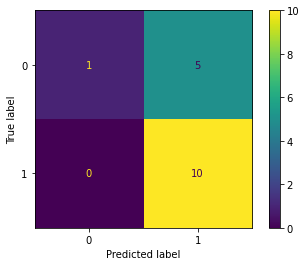

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# generate predictions for the test set
y_pred = np.round(base_model.predict(X_test))

# calculate the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

# create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix)

# plot the confusion matrix
disp.plot()
plt.show()

## Conlcusion 
The base model succesfully compiles and fits without any errors or warnings. The model also performs decently for a baseline model. I will continue tuning and optimizing thhe model in the [modeling notebook](/PROJECT-2/modeling.ipynb).  